In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [37]:
import time
import glob
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import SimpleITK as sitk
import pydicom
import nibabel as nib

import torch
from torch.utils.data import DataLoader, random_split

from src.data import NSCLCDataset
from src.utils import profile_load_time
from src.visualization import plot_batch
from src.preprocess import DEFAULT_TRANSFORM

In [24]:
ds = NSCLCDataset(ct_dir="data/raw/NSCLC-Radiomics/",
                  mask_dir="data/processed/NSCLC_ground_truths/",
                  ct_ids=["LUNG1-001", "LUNG1-002"],
                  transform=DEFAULT_TRANSFORM)

Caching CT scans metadata: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


In [10]:
a, b = ds.metadata.iloc[0]
len(ds.metadata)

245

In [9]:
df = pd.read_csv("data/processed/NSCLC-Radiomics_metadata.csv")
df.head()

,img_path,mask_path
0,/storage/ducpm/lung-segmentation/data/raw/NSCL...,/storage/ducpm/lung-segmentation/data/processe...
1,/storage/ducpm/lung-segmentation/data/raw/NSCL...,/storage/ducpm/lung-segmentation/data/processe...
2,/storage/ducpm/lung-segmentation/data/raw/NSCL...,/storage/ducpm/lung-segmentation/data/processe...
3,/storage/ducpm/lung-segmentation/data/raw/NSCL...,/storage/ducpm/lung-segmentation/data/processe...
4,/storage/ducpm/lung-segmentation/data/raw/NSCL...,/storage/ducpm/lung-segmentation/data/processe...


In [4]:
with open("data/processed/NSCLC-Radiomics_train_metadata.pkl", 'rb') as f:
    train_dict = pickle.load(f)
with open("data/processed/NSCLC-Radiomics_val_metadata.pkl", 'rb') as f:
    val_dict = pickle.load(f)

In [26]:
rows = []
for d in [train_dict, val_dict]:
    for sample_idx, (_, img_path, mask_path) in sorted(d.items()):
        rows.append({"img_path": img_path, "mask_path": mask_path})
metadata = pd.DataFrame(rows, columns=["img_path", "mask_path"])
metadata.to_csv("data/processed/NSCLC-Radiomics_metadata.csv", index=False)

In [52]:
# testing
full_ds = NSCLCDataset(metadata_path="data/processed/NSCLC-Radiomics_metadata.csv",
                  transform=DEFAULT_TRANSFORM)
loader = DataLoader(full_ds, batch_size=16, shuffle=True)
batch_gen = iter(loader)

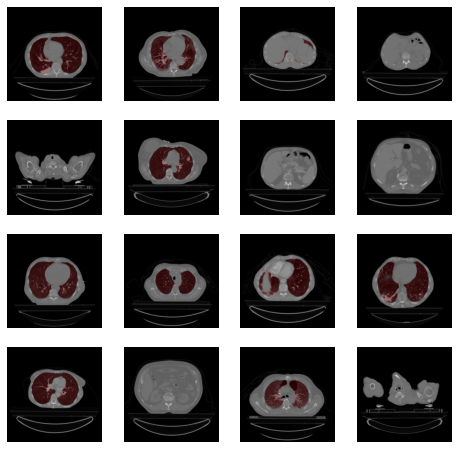

In [30]:
batch = next(batch_gen)
X_batch, y_batch = batch["ct_slice"], batch["seg_mask"]
plot_batch(X_batch, y_batch, nrows=4, ncols=4, figsize=(8,8))

In [54]:
# test torch random subsets
train_ratio = 0.8
num_train = int(train_ratio * len(full_ds))
num_val = len(full_ds) - num_train

train_ds, val_ds = random_split(full_ds, lengths=[num_train, num_val],
                                generator=torch.Generator().manual_seed(25))
len(train_ds), len(val_ds)

(38807, 9702)